In [25]:
import numpy as np
import pandas as pd


In [26]:
df = pd.read_csv("datasets/cleaned_online_sex_work.csv")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   User_ID                              28831 non-null  int64  
 1   Female                               28831 non-null  bool   
 2   Age                                  28831 non-null  float64
 3   Location                             28831 non-null  object 
 4   Verification                         28831 non-null  bool   
 5   Heterosexual                         28831 non-null  int64  
 6   Homosexual                           28831 non-null  int64  
 7   bicurious                            28831 non-null  int64  
 8   bisexual                             28831 non-null  int64  
 9   Dominant                             28831 non-null  int64  
 10  Submisive                            28831 non-null  int64  
 11  Switch                      

### Data preprocessing

In [28]:
truth_map = {True: 1, False: 0}

df['Female'] = df['Female'].map(truth_map)
df['Verification'] = df['Verification'].map(truth_map)

#too many categories, so we take the top 10 and make dummies
top_10 = df['Location'].value_counts().head(10).index.to_list()

def dummies(d, var, top10):
    for label in top10:
        d[var+'_'+label] = np.where(df[var] == label, 1, 0)

dummies(df, 'Location', top_10)
df.drop('Location', axis = 1, inplace = True)

df.drop(['User_ID', 'Friends_ID_list'], axis = 1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Female                               28831 non-null  int64  
 1   Age                                  28831 non-null  float64
 2   Verification                         28831 non-null  int64  
 3   Heterosexual                         28831 non-null  int64  
 4   Homosexual                           28831 non-null  int64  
 5   bicurious                            28831 non-null  int64  
 6   bisexual                             28831 non-null  int64  
 7   Dominant                             28831 non-null  int64  
 8   Submisive                            28831 non-null  int64  
 9   Switch                               28831 non-null  int64  
 10  Men                                  28831 non-null  int64  
 11  Men_and_Women               

In [30]:
from tensorflow import keras
import keras_tuner as kt

In [31]:
def build_model(hp):
    ''' 
    model-building function given the hyperparameters
    '''
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=10, max_value=400, step=10),
                activation=hp.Choice("activation", ["relu", "tanh", "swish"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=0.20))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = build_model(kt.HyperParameters())

In [32]:
def get_best_model(tuner):
    ''' 
    gets best model after searching
    '''
    models = tuner.get_best_models(num_models=2)
    best_model = models[0]
    best_model.build(input_shape=(None, 18))
    return best_model

In [33]:
def define_tuner():
  ''' 
  tuner which searches for best hyperparameters
  '''
  return kt.RandomSearch(
      hypermodel=build_model,
      objective="val_accuracy",
      max_trials=10,
      executions_per_trial=1,
      overwrite=True,
      project_name="helloworld"
  )

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def scaled_splits(df):
    '''
    returns train and test splits and scales them for training in model
    '''
    X = df.drop(['Risk'], axis =1)
    y = df['Risk'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y_train.reshape(y_train.shape[0], 1)
    return X_train, X_test, y_train, y_test

In [35]:
def get_pseudo_labels(model, unlabelled_df):
    ''' 
    finds pseudolabels for a given unlabelled set of data
    '''
    return model.predict(unlabelled_df)

In [36]:
def get_confident_labels(pseudolabels):
    ''' 
    filters prediction based on how confident the model is in predicting the output
    '''
    confidence_level = np.percentile(pseudolabels, 90)
    confident_labels = []
    for i in pseudolabels:
        value = i[0]
        if value >= confidence_level:
            confident_labels.append([1, 1])
        elif value <= 1-confidence_level:
            confident_labels.append([0, 1])
        else:
            confident_labels.append([value, 0])
    return pd.DataFrame(confident_labels, columns=["Risk", "confident"])


In [38]:
# defined callback with patience 10 to prevent overfitting

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [39]:
def self_training(labelled_df, unlabelled_df, current_model=None):
    ''' 
    single iteration of self-training
    '''
    if len(unlabelled_df) > 0: 

        # training model with labelled set of data
        xtrain, xtest, ytrain, ytest = scaled_splits(labelled_df)
        tuner = define_tuner()
        tuner.search(xtrain, ytrain, epochs = 20, validation_data = (xtest,ytest), callbacks = [early_stop])
        best_hps = tuner.get_best_hyperparameters(5)
        model = build_model(best_hps[0])

        unlabelled_df = unlabelled_df.drop('Risk', axis = 1)

        #finding pseudolabels for unlabelled data
        pseudolabels = get_pseudo_labels(model, unlabelled_df)

        confidence_df = get_confident_labels(pseudolabels)

        # dataframe which contains unlabelled data along with pseudolabel and whether or not prediction is confident
        u_conf = pd.concat([confidence_df.reset_index(), unlabelled_df.reset_index()], axis = 1)

        unconfident_rows = u_conf[u_conf['confident'] == 0]
        confident_rows = u_conf[u_conf['confident'] == 1]
        unconfident_rows.drop('index', axis = 1, inplace = True)
        confident_rows.drop('index', axis = 1, inplace = True)

        # adding confident labels to labelled set
        new_labelled_df = pd.concat([labelled_df, confident_rows.drop(['confident'], axis = 1)], axis = 0)

        # new unlabelled set is the uncofident predictions
        new_unlabelled_df = unconfident_rows.drop('confident', axis = 1)
        return {
            'labelled_df': new_labelled_df,
            'unlabelled_df': new_unlabelled_df,
            'model': model,
            'hyperparams': best_hps[0]
        }
    else:
        return current_model

In [40]:
l = df.dropna()
u = df[df['Risk'].isna()]

In [41]:
# labelled dataset

l

,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,Switch,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O
0,0,34.6,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,32.2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,33.6,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,34.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,39.5,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0,29.9,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
86,0,52.3,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
87,1,28.8,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
88,1,34.2,1,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [42]:
# unlabelled_dataset

u

,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,Switch,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O
90,0,42.9,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
91,0,47.4,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
92,0,35.2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
93,1,28.6,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
94,0,56.6,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,0,27.2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28827,0,46.4,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28828,0,28.8,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
28829,0,31.5,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Function below takes very long to run, automates the iterations of self-training using recursion

In [43]:
# automating it
'''
def self_training_auto(labelled, unlabelled, current_model = None):
    if len(unlabelled) > 0:
        o = self_training(labelled, unlabelled)
        print('\n\nlabelled: \n\n', o['labelled_df'], '\n\n unlabelled \n\n', o['unlabelled'])`
        self_training_auto(o['labelled_df'], o['unlabelled_df'], o['model'])
    else:
        return {
            'final_model': current_model,
            'l': labelled,
            'u': unlabelled
        }
 '''       

"\ndef self_training_auto(labelled, unlabelled, current_model = None):\n    if len(unlabelled) > 0:\n        o = self_training(labelled, unlabelled)\n        print('\n\nlabelled: \n\n', o['labelled_df'], '\n\n unlabelled \n\n', o['unlabelled'])`\n        self_training_auto(o['labelled_df'], o['unlabelled_df'], o['model'])\n    else:\n        return {\n            'final_model': current_model,\n            'l': labelled,\n            'u': unlabelled\n        }\n "

In [44]:
#out = self_training_auto(l, u)

In [45]:
# first iteration of self-training
iter1 = self_training(l, u)

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.6111111044883728

Best val_accuracy So Far: 0.7777777910232544
Total elapsed time: 00h 00m 26s


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### As we can see, more rows have been added to labelled set and confidently predicted rows have been removed from unlabelled set

In [46]:
iter1['labelled_df']

,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,Switch,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O
0,0,34.6,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,32.2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,33.6,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,34.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,39.5,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28735,0,43.9,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
28736,0,27.2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28737,0,46.4,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28738,0,28.8,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
iter1['unlabelled_df']

,Risk,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O
0,2.191013e-28,0,42.9,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,5.878075e-29,0,47.4,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,2.087084e-29,1,28.6,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,9.309520e-29,0,56.6,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,5.878075e-29,0,47.4,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28730,4.516721e-29,1,41.7,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
28732,7.389968e-35,0,32.4,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
28733,8.701633e-01,0,58.5,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
28734,1.369167e-28,0,50.5,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# second iteration  of self-training
iter2 = self_training(iter1['labelled_df'], iter1['unlabelled_df'])

Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.9794871807098389

Best val_accuracy So Far: 0.9969230890274048
Total elapsed time: 00h 05m 57s


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
iter2['labelled_df']

,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,Switch,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O
0,0,34.6,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,32.2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,33.6,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,34.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,39.5,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,1,41.7,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
14206,0,32.4,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14207,0,58.5,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14208,0,50.5,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
iter2['unlabelled_df']

,Risk,Female,Age,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,Submisive,...,Location_A,Location_B,Location_G,Location_L,Location_M,Location_K,Location_C,Location_H,Location_E,Location_O


#### In this case, all labels have been confidently labelled in 2 iterations but this may not always be the case (depends on data and some randomess)

In [57]:
final_labelled_df = iter2['labelled_df']

In [58]:
final_labelled_df['Risk'].value_counts()

1.0    14695
0.0    14136
Name: Risk, dtype: int64

In [59]:
# structure of final model

model2 = iter2['model']
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 320)               11840     
_________________________________________________________________
dense_10 (Dense)             (None, 220)               70620     
_________________________________________________________________
dense_11 (Dense)             (None, 210)               46410     
_________________________________________________________________
dense_12 (Dense)             (None, 270)               56970     
_________________________________________________________________
dropout_1 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [80]:
# callbacks to slow down training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)


In [81]:
# training a new model with best hyperparams to the enitre labelled dataset

params = iter2['hyperparams']
model = build_model(params)
x1, x2, y1, y2 = scaled_splits(final_labelled_df)
history = model.fit(x1, y1, epochs=100, validation_data = (x2, y2), callbacks=[early_stop])
hist = pd.DataFrame(history.history)

Epoch 1/100
721/721 [==============================] - 4s 5ms/step - loss: 0.1499 - accuracy: 0.9448 - val_loss: 0.1026 - val_accuracy: 0.9719
Epoch 2/100
721/721 [==============================] - 3s 4ms/step - loss: 0.1039 - accuracy: 0.9659 - val_loss: 0.0927 - val_accuracy: 0.9700
Epoch 3/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0941 - accuracy: 0.9691 - val_loss: 0.0966 - val_accuracy: 0.9667
Epoch 4/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0829 - accuracy: 0.9726 - val_loss: 0.0908 - val_accuracy: 0.9726
Epoch 5/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0746 - accuracy: 0.9750 - val_loss: 0.0818 - val_accuracy: 0.9790
Epoch 6/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0722 - accuracy: 0.9750 - val_loss: 0.0666 - val_accuracy: 0.9782
Epoch 7/100
721/721 [==============================] - 3s 4ms/step - loss: 0.0667 - accuracy: 0.9772 - val_loss: 0.0673 - val_accuracy: 0.9775

<AxesSubplot:>

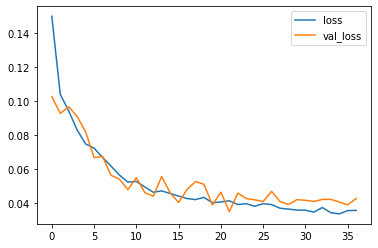

In [82]:
hist[['loss', 'val_loss']].plot()

<AxesSubplot:>

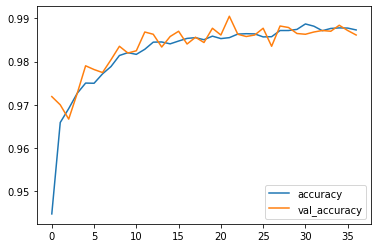

In [83]:
hist[['accuracy', 'val_accuracy']].plot()

In [89]:
preds = model.predict(x2)
new_preds = []
for i in preds:
    if i > 0.5:
        new_preds.append(1)
    else:
        new_preds.append(0)

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y2, new_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2821
         1.0       0.99      0.99      0.99      2946

    accuracy                           0.99      5767
   macro avg       0.99      0.99      0.99      5767
weighted avg       0.99      0.99      0.99      5767

